In [47]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [48]:
BATCH_SIZE = 32 #represents the number of images to be processed in each batch during training.
IMAGE_SIZE = 256 #defines the desired size for input images.
CHANNELS=3 # specifies the number of color channels in the images (RGB has 3 channels).
EPOCHS=50 #represents the number of training epochs (iterations)

In [49]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Food Items",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 181 files belonging to 4 classes.


In [50]:
class_names = dataset.class_names
class_names ## the different categories 

['French Fries', 'Ice Cream', 'Pizza', 'Sushi']

In [51]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 3 0 1 1 1 1 1 3 1 3 2 1 3 1 0 2 2 0 1 3 2 2 0 0 0 0 2 2]


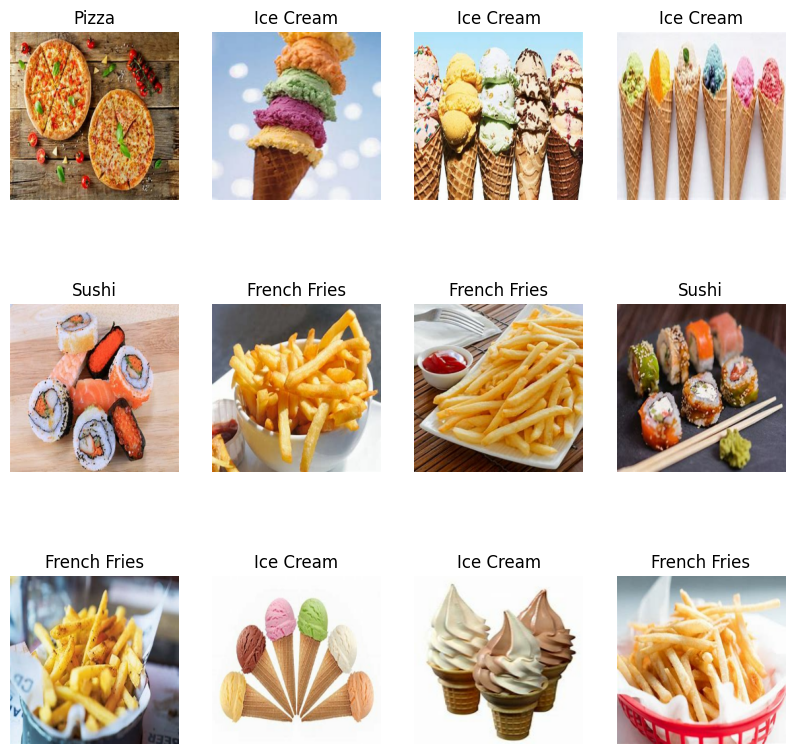

In [52]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [53]:
len(dataset)

6

Training Testing and Validation

In [54]:
train_size = 0.8
len(dataset)*train_size

4.800000000000001

In [55]:
train_ds = dataset.take(54)
len(train_ds)

6

In [56]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [57]:
val_size=0.1
len(dataset)*val_size

0.6000000000000001

In [58]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [59]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [60]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ### training, testing and validation dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [61]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [62]:
len(train_ds)

4

In [63]:
len(val_ds)

0

In [64]:
len(test_ds)

2

In [65]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [66]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [67]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [68]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
     

In [69]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [70]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [71]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [73]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
4/4 [==============================] - 19s 4s/step - loss: 0.8154 - accuracy: 0.5983
Epoch 2/50
4/4 [==============================] - 17s 4s/step - loss: 0.7907 - accuracy: 0.5897
Epoch 3/50
4/4 [==============================] - 16s 4s/step - loss: 0.7878 - accuracy: 0.6154
Epoch 4/50
4/4 [==============================] - 16s 4s/step - loss: 0.7777 - accuracy: 0.6239
Epoch 5/50
4/4 [==============================] - 17s 4s/step - loss: 0.7635 - accuracy: 0.6325
Epoch 6/50
4/4 [==============================] - 16s 4s/step - loss: 0.7937 - accuracy: 0.5897
Epoch 7/50
4/4 [==============================] - 17s 3s/step - loss: 0.7793 - accuracy: 0.6581
Epoch 8/50
4/4 [==============================] - 16s 4s/step - loss: 0.7543 - accuracy: 0.6581
Epoch 9/50
4/4 [==============================] - 16s 4s/step - loss: 0.6769 - accuracy: 0.7521
Epoch 10/50
4/4 [==============================] - 16s 4s/step - loss: 0.6434 - accuracy: 0.7436
Epoch 11/50
4/4 [======================

In [74]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 3s 1s/step - loss: 0.3046 - accuracy: 0.9062


In [75]:
scores

[0.3045942783355713, 0.90625]

In [77]:
history

In [78]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 4}

In [79]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [80]:
type(history.history['loss'])

list

In [81]:
len(history.history['loss'])

50

In [82]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8154478073120117,
 0.7907382845878601,
 0.7877699732780457,
 0.7777436375617981,
 0.7634886503219604]

first image to predict
actual label: Sushi
1/1 [==============================] - 3s 3s/step
predicted label: Sushi


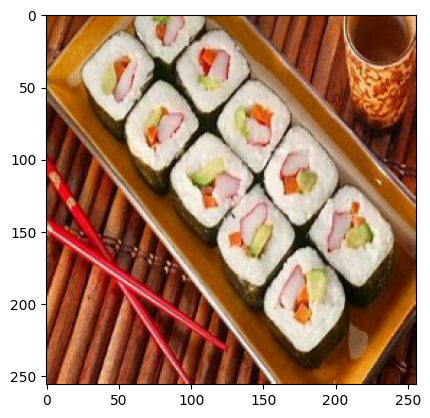

In [83]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8') #extracts the first image from the batch and converts it to a NumPy array.
    first_label = labels_batch[0].numpy() #retrieves the corresponding label for the first image in the batch.
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [84]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # converts the input image (in NumPy array format) to a TensorFlow tensor
    img_array = tf.expand_dims(img_array, 0) #reshapes the tensor to have a batch dimension of 1, as the model expects input in batch format.

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 83ms/step


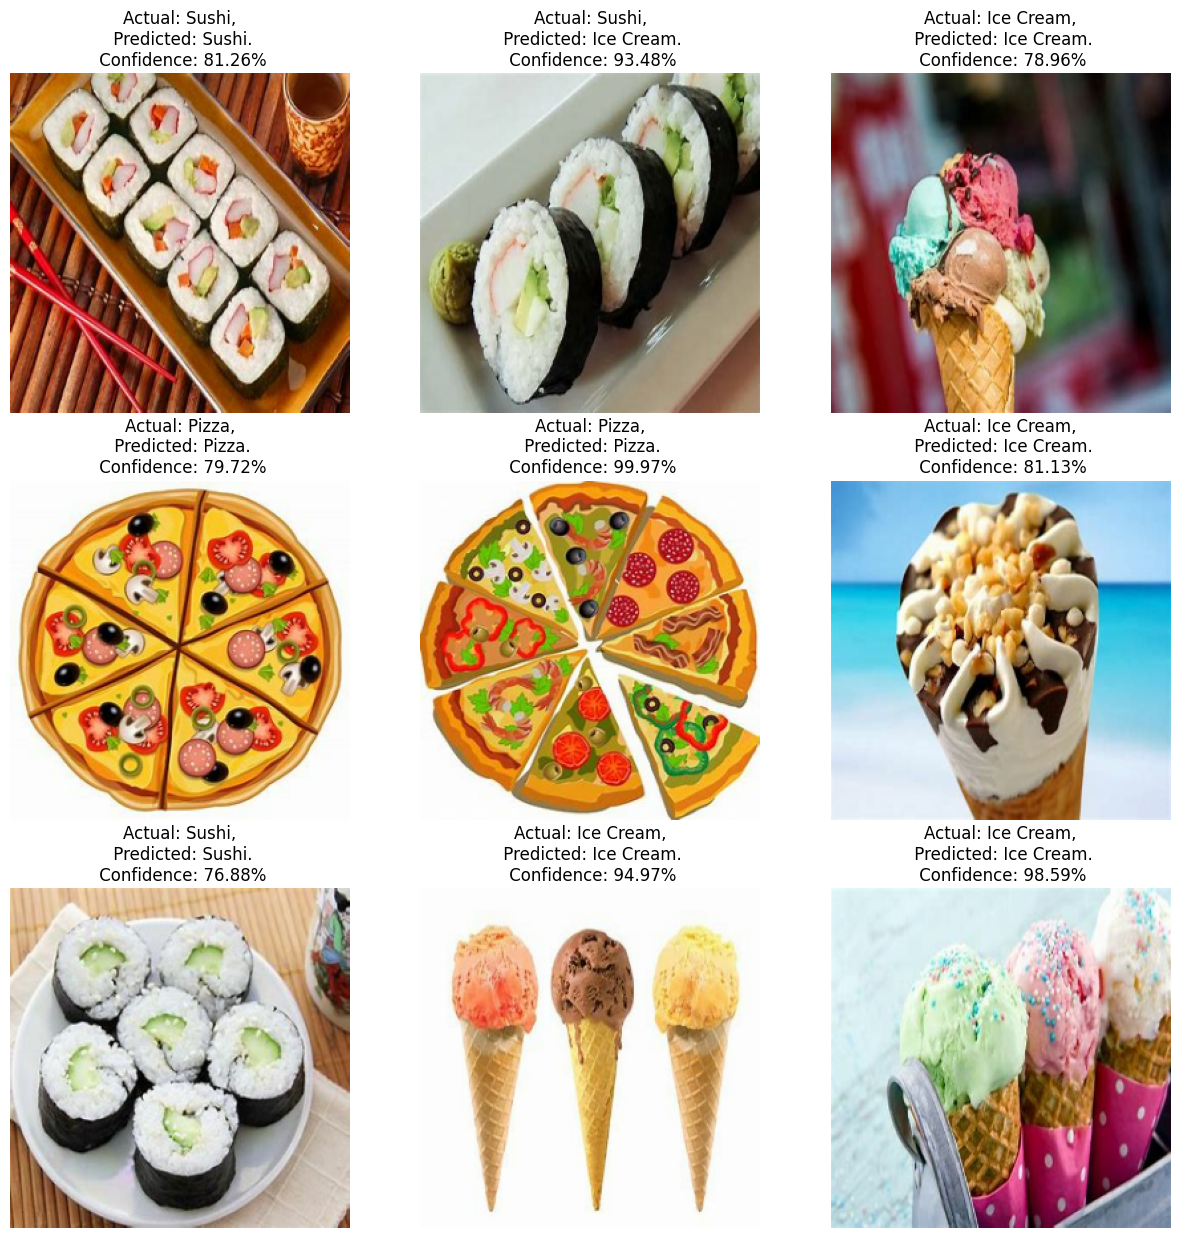

In [85]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] ### the actual class 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        ## predicted class 
        plt.axis("off")

In [86]:
model.save('./models', save_format='tf')

In [87]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import gradio as gr

In [89]:
def predict_image(img):
  img_4d=img.reshape(-1,256,256,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(4)}

In [90]:
image = gr.inputs.Image(shape=(256,256)) ### 256x256 pixel 
label = gr.outputs.Label(num_top_classes=4) ## 4 predicted classes

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 164ms/step
Keyboard interruption in main thread... closing server.
